In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
import sys
sys.path.append('./')
sys.path.append('../')

In [202]:
from segmentation import * 
from matplotlib import pyplot as plt

In [203]:
z = zarr.open('anno_alice_T2030_tiny_2.zarr', 'a')
channel, time, *_ = z['Raw'].shape
frag_t = []

In [204]:
t = 0

In [230]:
def get_fragments2(image):
    """Apply watershed to an image to get (over-)segmentation fragments.

    Parameters
    ----------
    image: array
        Boundary prediction image.
    """
    # normalized to 255 can get better watershed output
    inputimage = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # watershed algorithm set local minima as seed
    minima = mh.regmin(inputimage)
    markers, nr_markers = mh.label(minima)
    fragments = mh.cwatershed(inputimage, markers, return_lines=False)
    fragments = fragments.astype('uint64')

    # Do WaterZ
    affs = get_affinities(image)
    gen = waterz.agglomerate(affs, [0.5], fragments=fragments,
                         return_merge_history=False,
                         return_region_graph=False)
    fragments  = next(gen)
    fragments = fragments.astype('uint64')
    
    return fragments

In [231]:
image = z['Raw'][3, t, :, :, :]
affs = get_affinities(image)
fragments = get_fragments2(image)
#thresholds = [0, 0.5]
thresholds = [0, 1]
frag_t.append(fragments.copy())
gen = waterz.agglomerate(affs, thresholds, fragments=fragments,
                         return_merge_history=True,
                         return_region_graph=True)
# the initial seg is the fragments, with threshold=0
segs, _, _ = next(gen)
# prevent generator change data in RAM 
seg = segs.copy()
print('labels:', len(np.unique(seg)))
# Fragment values in segs starts at 1
ids, positions, volumes = segment_stats(fragments, t)
z['Fragment_stats/id/'+str(t)] = np.array(ids)
z['Fragment_stats/Position/'+str(t)] = np.array(positions)
z['Fragment_stats/Volume/'+str(t)] = np.array(volumes)

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 89 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 370
merging until threshold 0.5
computing initial scores
merging until 0.5
min edge score 0.0492454
threshold exceeded
merged 50 edges
extracting segmentation
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 89 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 129
merging until threshold 0
computing initial scores
merging until 0
min edge score 0.512486
threshold exceeded
merged 0 edges
labels: 38


In [220]:
_, merges, _ = next(gen)

merging until threshold 1
merging until 1
min edge score 0.512486
merged 37 edges
extracting segmentation


In [185]:
def unique_merges(rows):
    merged = {}
    u_merges = []
    
    for m in rows:
        key = m['b']
        if not merged.get(key):
            u_merges.append(m)
            merged[key] = 1
        
    return u_merges
merges = unique_merges(merges)

In [221]:
merges

[{'a': 14, 'b': 16, 'c': 14, 'score': 0.5124858021736145},
 {'a': 4, 'b': 28, 'c': 4, 'score': 0.5264488458633423},
 {'a': 14, 'b': 19, 'c': 14, 'score': 0.5339860916137695},
 {'a': 5, 'b': 10, 'c': 5, 'score': 0.5435411930084229},
 {'a': 7, 'b': 51, 'c': 7, 'score': 0.5494364500045776},
 {'a': 45, 'b': 82, 'c': 45, 'score': 0.5684003233909607},
 {'a': 14, 'b': 15, 'c': 14, 'score': 0.587851881980896},
 {'a': 11, 'b': 12, 'c': 11, 'score': 0.5932518243789673},
 {'a': 78, 'b': 79, 'c': 78, 'score': 0.6139891147613525},
 {'a': 7, 'b': 33, 'c': 7, 'score': 0.6389403939247131},
 {'a': 4, 'b': 7, 'c': 4, 'score': 0.7017139196395874},
 {'a': 50, 'b': 59, 'c': 50, 'score': 0.7084683179855347},
 {'a': 41, 'b': 45, 'c': 41, 'score': 0.7269359827041626},
 {'a': 56, 'b': 81, 'c': 56, 'score': 0.7339800596237183},
 {'a': 13, 'b': 24, 'c': 13, 'score': 0.7472824454307556},
 {'a': 2, 'b': 4, 'c': 2, 'score': 0.7526383996009827},
 {'a': 14, 'b': 39, 'c': 14, 'score': 0.7529534101486206},
 {'a': 2, 'b

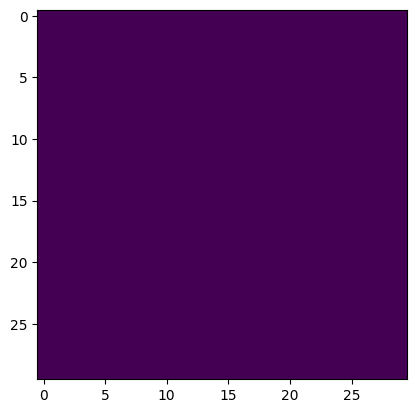

In [222]:
fig = plt.figure()
plt.imshow(segs[10])
plt.show()

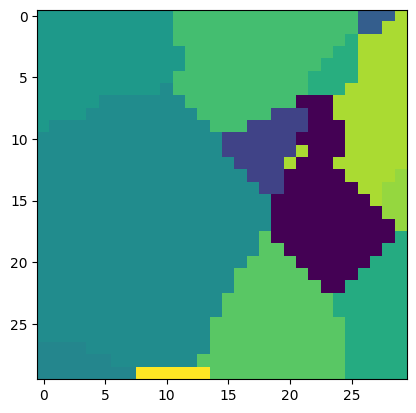

In [223]:
fig = plt.figure()
plt.imshow(seg[10])
plt.show()

In [224]:
len(np.unique(seg))

38

In [225]:
def merged_position(fragments, a, b, t):
    """
    Merge 'a' and 'b' into 'w'

    return a center point: tuple float
    """
    merge_mask = np.zeros((fragments.shape), dtype='int')
    merge_mask[seg == a] = 1
    merge_mask[seg == b] = 1
    region = regionprops(merge_mask)
    z, y, x = region[0].centroid
    position = (t, int(z), int(y), int(x))
    # TODO shifting bits can be set by parameter.
    id = encode64((t, int(z), int(y), int(x), int(region[0].area)),bits=[9,12,12,12,19])
    return id, position, region[0].area

def mask(img, label):
    mask = np.zeros((img.shape), dtype='int')
    mask[img == label] = 1
    return mask

In [226]:
merge_tree = np.empty((len(merges), 3), dtype=np.uint64)
merge_scores = np.empty((len(merges),))
# Separately store the stats for the whole merge tree!
merge_positions = {} 
merge_volumes = {}
merge_parents = {}

In [227]:
merge_tree

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint64)

In [228]:
for i, merge in enumerate(merges):
    #merge = merges[0]
    print('- merges: %s / %s' % (i, len(merges)))
    print(merge)
    a, b, c = merge['a'], merge['b'], merge['c']
    score = merge['score']
    
    f_u = mask(seg, a)
    u, pos_u, vol_u = merge_stats(f_u, t)
    f_v = mask(seg, b)
    v, pos_v, vol_v = merge_stats(f_v, t)

    # Create the merged node
    w, pos_w, vol_w = merged_position(seg, a, b, t)  # index+1 = label
    # merge a,b in to a
    seg[seg == b] = a
    # Add to merge tree
    merge_tree[i] = u, v, w
    merge_scores[i] = score
    # Add to merge stats
    merge_volumes.update({u: vol_u, v: vol_v, w: vol_w})
    merge_parents.update({u: w, v: w, w: w})
    merge_positions.update({u: pos_u, v: pos_v, w: pos_w})

- merges: 0 / 37
{'a': 14, 'b': 16, 'c': 14, 'score': 0.5124858021736145}
- merges: 1 / 37
{'a': 4, 'b': 28, 'c': 4, 'score': 0.5264488458633423}
- merges: 2 / 37
{'a': 14, 'b': 19, 'c': 14, 'score': 0.5339860916137695}
- merges: 3 / 37
{'a': 5, 'b': 10, 'c': 5, 'score': 0.5435411930084229}
- merges: 4 / 37
{'a': 7, 'b': 51, 'c': 7, 'score': 0.5494364500045776}
- merges: 5 / 37
{'a': 45, 'b': 82, 'c': 45, 'score': 0.5684003233909607}
- merges: 6 / 37
{'a': 14, 'b': 15, 'c': 14, 'score': 0.587851881980896}
- merges: 7 / 37
{'a': 11, 'b': 12, 'c': 11, 'score': 0.5932518243789673}
- merges: 8 / 37
{'a': 78, 'b': 79, 'c': 78, 'score': 0.6139891147613525}
- merges: 9 / 37
{'a': 7, 'b': 33, 'c': 7, 'score': 0.6389403939247131}
- merges: 10 / 37
{'a': 4, 'b': 7, 'c': 4, 'score': 0.7017139196395874}
- merges: 11 / 37
{'a': 50, 'b': 59, 'c': 50, 'score': 0.7084683179855347}
- merges: 12 / 37
{'a': 41, 'b': 45, 'c': 41, 'score': 0.7269359827041626}
- merges: 13 / 37
{'a': 56, 'b': 81, 'c': 56, '

In [229]:
merge_tree

array([[   809283545464832,   4925855092441088,   5735095648387072],
       [  2427936428785664,   9112975713503232,  11540697387632128],
       [  5735095648387072,    633344526123008,   6368414345986048],
       [ 13757115273314816,    422255446196224,  14179327740477952],
       [ 53234143984617984,   6333384552877056,  59567330958510592],
       [ 29132694457684992,    809352231393792,  29941943605663232],
       [  6368414345986048,   1477820981182464,   7846157973716992],
       [  1161256111177728,    457551493726208,   1618652948332544],
       [   387045272852992,   1020424099994112,   1407435013102080],
       [ 59567330958510592,   4538973003186688,  64106114955872768],
       [ 11540697387632128,  64106114955872768,  75646597586749440],
       [ 16009121278988800,  25860668156548096,  41869591816705024],
       [104814296025797120,  29941943605663232, 134756196667101696],
       [ 25332893939143680,    105767864638464,  25438447055410176],
       [  1196500614905856,   9148

In [90]:
pos_v

(0, 0, 1, 18)

In [91]:
vol_v

74.0